# 07. In silico perturbation
This notebook will introduce the usage of in silico perturbation with vector field.

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd

import torch
import pygot
import celloracle as co
from tqdm import tqdm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
#import pertpy as pt
plt.rc('axes.spines', top=False, right=False)
%matplotlib inline

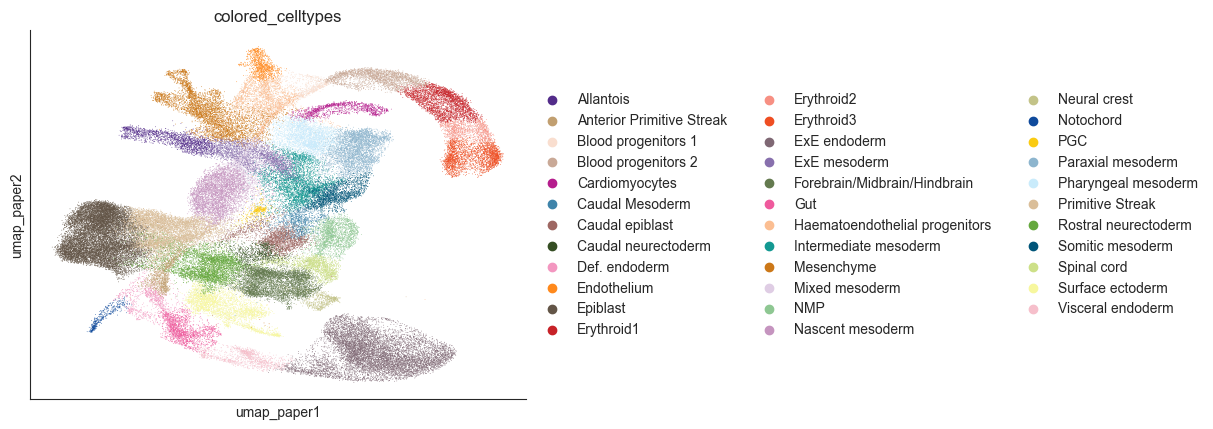

In [7]:
adata = sc.read('../../pygot_data/tutorial_data/GTL.h5ad')
cell_type_key = "colored_celltypes"
sc.pl.embedding(adata, basis="umap_paper", color=cell_type_key)

# Translate the temporal annotation into numeric format
adata.obs['stage_numeric'] = adata.obs['stage'].apply(lambda x: float(x[1:]))
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(np.float32)
#Extract only highly variable genes
adata = adata[:,adata.var['highly_variable']]

In [3]:
#Specify the temporal annotation, latent space
time_key = 'stage_numeric'
embedding_key = 'X_pca'
velocity_key = 'velocity_pca'


In [15]:
model = torch.load('../../pygot_data/tutorial_data/GTL_model.pkl')
adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model, time_key=time_key, embedding_key=embedding_key, 
                                                  A=adata.varm['PCs'].T, dr_mode='linear')

## Compute cell type composition change under Tal1 KO 

The meta data of Tal1 KO is downloaded from https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-6967

In [6]:
tal1adata = sc.AnnData(obs=pd.read_csv('../pygot_data/Perturbation/chimera-tal1/meta.csv', index_col=0))
celltypelist = tal1adata.obs['celltype.mapped'].value_counts()[tal1adata.obs['celltype.mapped'].value_counts() >40].index.tolist()
tal1adata = tal1adata[tal1adata.obs['celltype.mapped'].isin(celltypelist)]
tal1adata.obs['sample'] = tal1adata.obs['sample'].astype(str)

In [7]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    tal1adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="celltype.mapped",
    sample_identifier="sample",
    covariate_obs=["tomato"],
)
sccoda_data

MuData object with n_obs × n_vars = 55993 × 27
  2 modalities
    rna:	55989 x 0
      obs:	'barcode', 'sample', 'stage', 'tomato', 'stage.mapped', 'celltype.mapped', 'closest.cell', 'haem_subclust.mapped', 'scCODA_sample_id'
    coda:	4 x 27
      obs:	'tomato', 'sample'
      var:	'n_cells'

Use the cell type composition information, we compute the log 2 cell type fraction change under Tal1 KO with scCODA

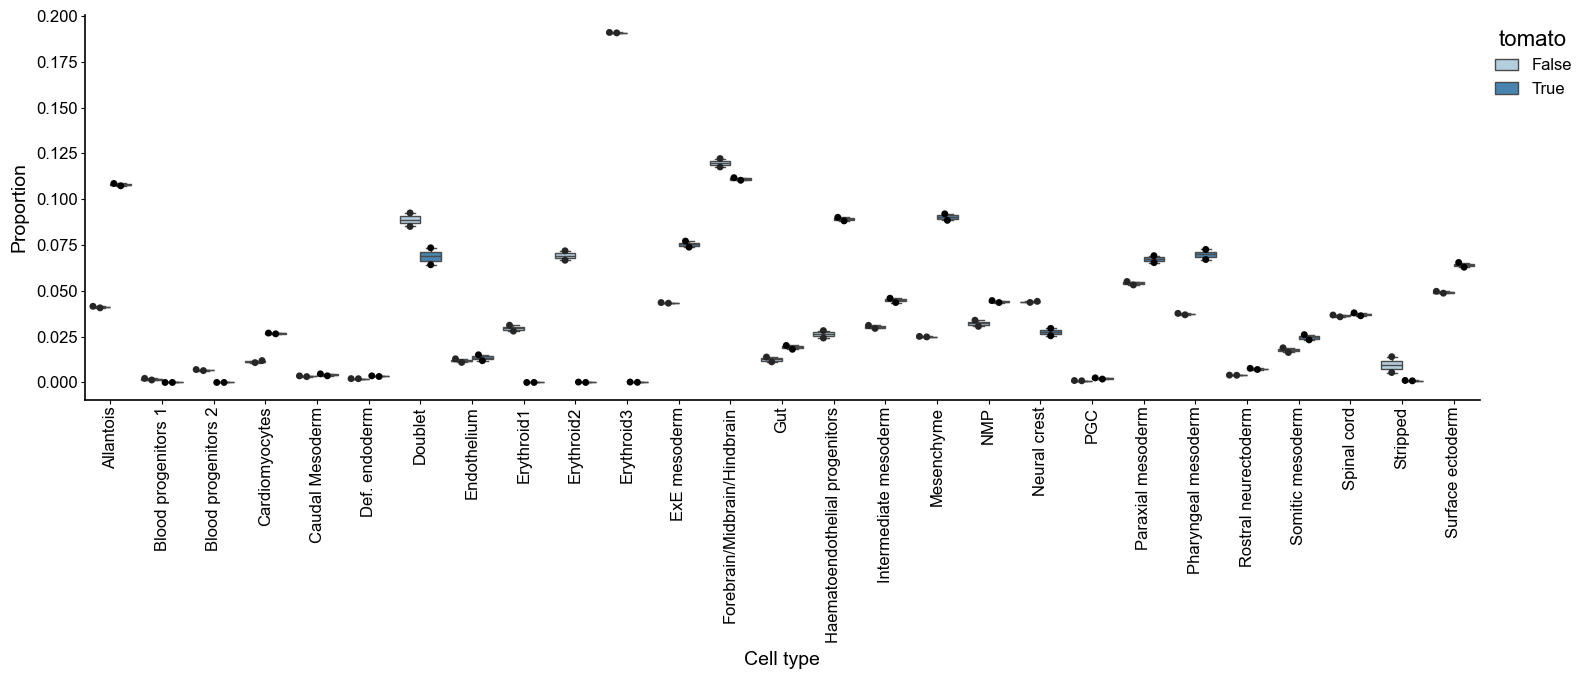

In [8]:
sccoda_model.plot_boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="tomato",
    figsize=(18, 5),
    add_dots=True,
    #args_swarmplot={"palette": ["red"]},
)

plt.show()

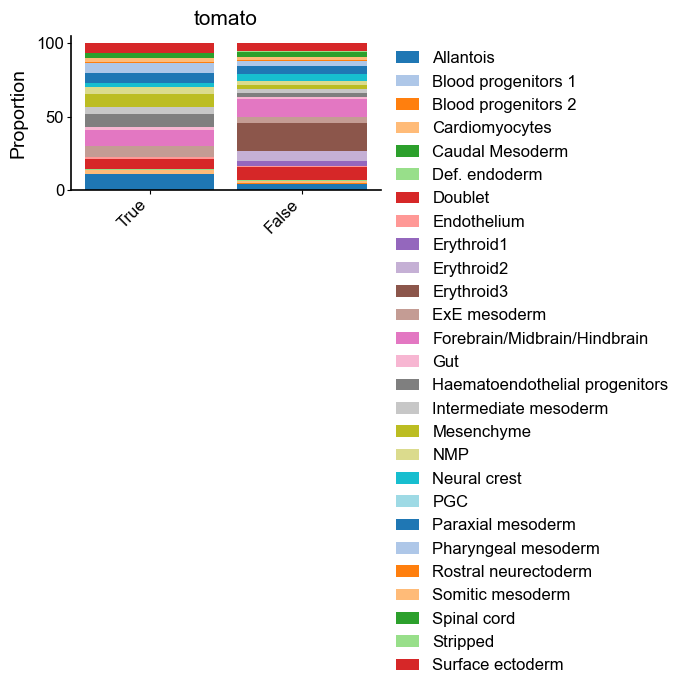

In [9]:
sccoda_model.plot_stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="tomato", figsize=(4, 2)
)
plt.show()

In [10]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="tomato",
    
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

• Automatic reference selection! Reference cell type set to Spinal cord
• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [08:05<00:00, 22.66it/s, 1023 steps of size 4.70e-03. acc. prob=0.84]


In [11]:
sccoda_data["coda"].varm["effect_df_tomato[T.True]"]

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
Allantois,0.711012,0.469,0.915,0.079,1.0000,1513.976276,1.392913
Blood progenitors 1,-2.966410,-4.540,-1.340,0.833,0.9990,1.549718,-3.912486
Blood progenitors 2,-4.260294,-5.742,-2.903,0.761,1.0000,1.695859,-5.779165
Cardiomyocytes,0.595252,0.041,0.828,0.160,0.9835,375.679086,1.225907
Caudal Mesoderm,0.000000,-0.509,0.376,0.095,0.1763,60.128452,0.367140
Def. endoderm,0.000000,-0.265,0.849,0.168,0.2281,42.034182,0.367140
Doublet,-0.507541,-0.626,-0.042,0.072,1.0000,964.820169,-0.365087
Endothelium,0.000000,-0.375,0.099,0.063,0.1513,202.448017,0.367140
Erythroid1,-5.673060,-7.089,-4.274,0.752,1.0000,1.833860,-7.817356


 Use FDR = 0.05 as cutoff to extract significantly change cell type 

In [39]:
sccoda_model.set_fdr(sccoda_data, 0.05)
coda_res = pd.DataFrame(sccoda_model.credible_effects(sccoda_data, modality_key="coda")).reset_index()
coda_res = coda_res.loc[coda_res['Final Parameter']]
coda_res['log2fc'] = sccoda_data["coda"].varm["effect_df_tomato[T.True]"].loc[coda_res['Cell Type']]['log2-fold change'].tolist()

In [40]:
benchmark_list = pd.Index(adata.obs['colored_celltypes'].unique()).intersection(coda_res['Cell Type'])

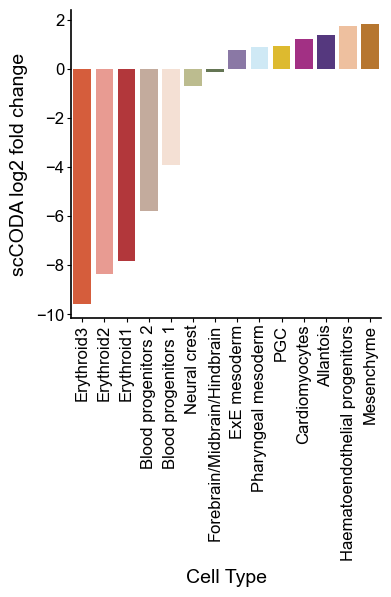

In [41]:
# Expectly, the population of erythroid lineage is dramaticly decreased
colors = { c:adata.uns['colored_celltypes_colors'][np.where(adata.obs['colored_celltypes'].cat.categories == c)[0][0]] for c in benchmark_list}
sns.barplot(coda_res.loc[coda_res['Cell Type'].isin(benchmark_list)].sort_values('log2fc'), x='Cell Type', y='log2fc', palette=colors)
plt.xticks(rotation=90)
plt.ylabel('scCODA log2 fold change')
plt.show()

In [13]:
coda_res

,Covariate,Cell Type,Final Parameter,log2fc
0,tomato[T.True],Allantois,True,1.378651
1,tomato[T.True],Blood progenitors 1,True,-3.926748
2,tomato[T.True],Blood progenitors 2,True,-5.793427
3,tomato[T.True],Cardiomyocytes,True,1.211645
5,tomato[T.True],Def. endoderm,True,0.621850
6,tomato[T.True],Doublet,True,-0.379350
8,tomato[T.True],Erythroid1,True,-7.831618
9,tomato[T.True],Erythroid2,True,-8.379551
10,tomato[T.True],Erythroid3,True,-9.585335
11,tomato[T.True],ExE mesoderm,True,0.782069


## Fit gene regulatory network from velocity
To conduct in silico perturbation, we first fit the gene regulatory network with gene velocity

In [16]:
grn_fitter = pygot.tl.analysis.GRN()
grn = grn_fitter.fit(adata, species='mm') # specifiy species, mm represents mouse

TF number: 334, Index(['Klf9', 'Zic5', 'Tfap2a', 'Tfap2b', 'Tfap2c', 'Ascl2', 'Mafb', 'Plagl1',
       'Osr2', 'Zic1',
       ...
       'Nanos1', 'Nuak2', 'Pgam2', 'Phlda2', 'Prnp', 'Rpp25', 'Sft2d1', 'Sim1',
       'Smpx', 'Tff3'],
      dtype='object', length=334)
scale velocity with factor : 12.324565810315601
l1_penalty: 0.005 min_beta: 1.0


Epoch [3741/10000], Train Loss: 76.5678, Val Loss: 85.5885:  37%|█████▉          | 3741/10000 [06:32<10:57,  9.52it/s]


Early stopping at epoch 3742. Best validation loss: 85.58825


 Use magic to impute expression with respect to the requirement of celloracle

In [17]:
import magic
adata.layers['raw_count'] = adata.X
mag = magic.MAGIC()
X_magic = mag.fit_transform(adata)
adata.layers['X_magic'] = adata.X
adata.layers['imputed_count'] = adata.layers['X_magic']

Calculating MAGIC...
  Running MAGIC on 98192 cells and 2500 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 29.16 seconds.
    Calculating KNN search...
    Calculated KNN search in 2377.72 seconds.
    Calculating affinities...
    Calculated affinities in 1730.63 seconds.
  Calculated graph and diffusion operator in 4137.81 seconds.
  Calculating imputation...
  Calculated imputation in 31.55 seconds.
Calculated MAGIC in 4169.87 seconds.


In [25]:

# Here, we conduct downsample to perform in silico perturbation, since celloracle'scality limitted to ~ 20k cells
sub_adata = adata[adata.obs.sample(n=10000).index]
sub_adata.obsm['X_umap_paper'] = sub_adata.obsm['X_umap_paper'].astype(np.float32)
oracle = co.Oracle()
oracle.import_anndata_as_normalized_count(sub_adata, cluster_column_name=cell_type_key, embedding_name='X_umap_paper')

In [26]:
# Export to celloracle
grn.export_grn_into_celloracle(oracle)

Finish!


## Perform in silico perturbation

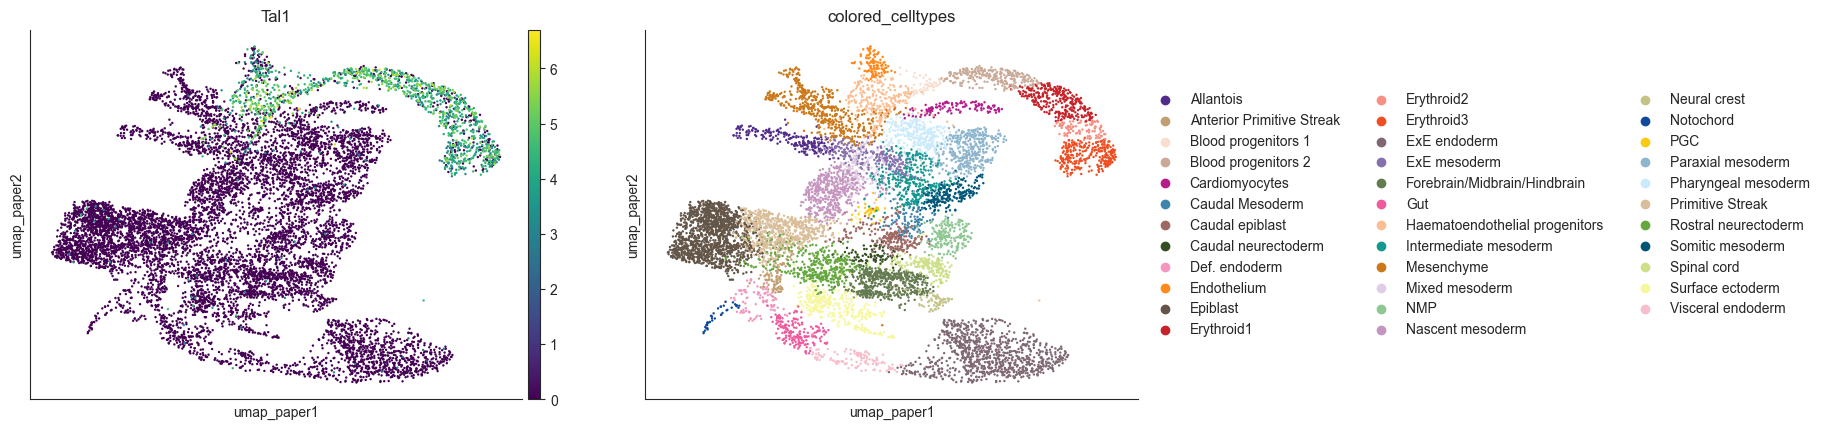

In [27]:
goi = 'Tal1'
sc.pl.embedding(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis", basis='umap_paper')
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

oracle.adata.layers['delta_X'] = oracle.adata.layers['delta_X'].astype(np.float64)
oracle.adata.layers['imputed_count'] = oracle.adata.layers['imputed_count'].astype(np.float64)

# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr=0.05)

# n_grid = 40 is a good starting value.
n_grid = 50 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

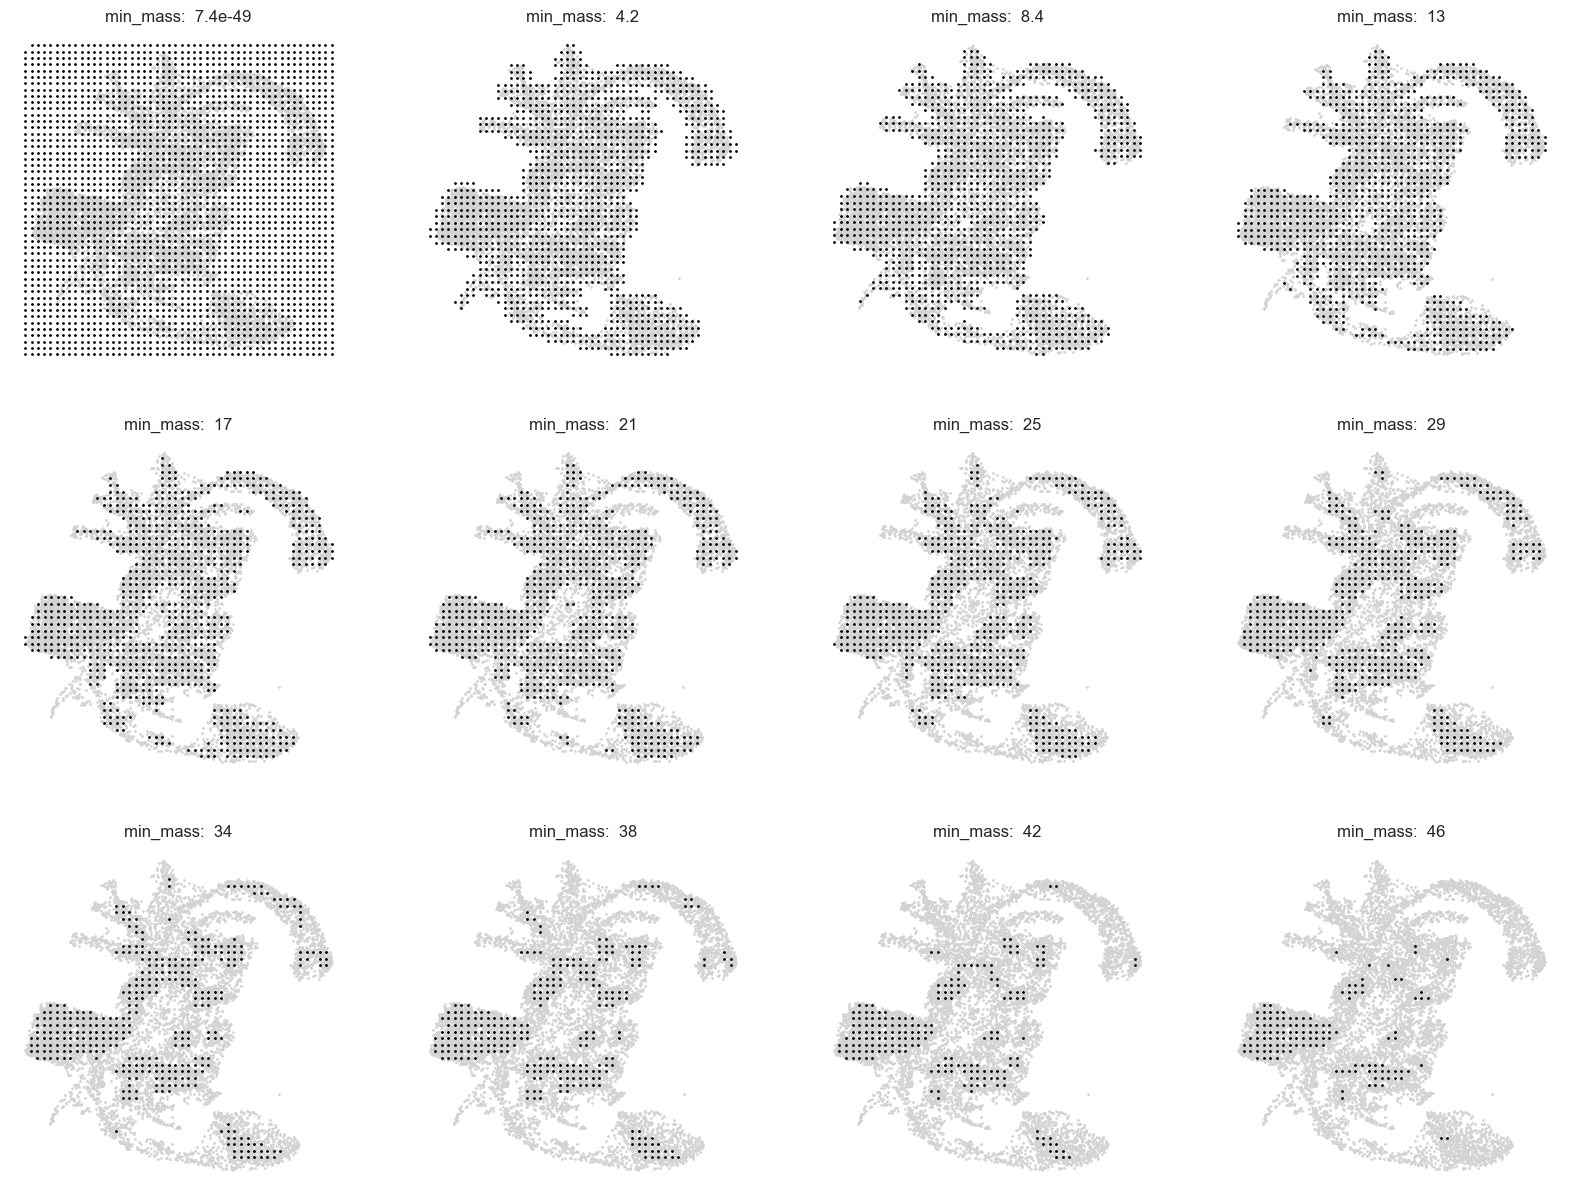

In [28]:
oracle.suggest_mass_thresholds(n_suggestion=12)

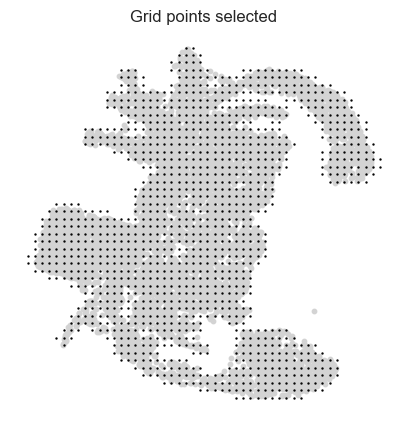

In [29]:
min_mass = 4.2
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

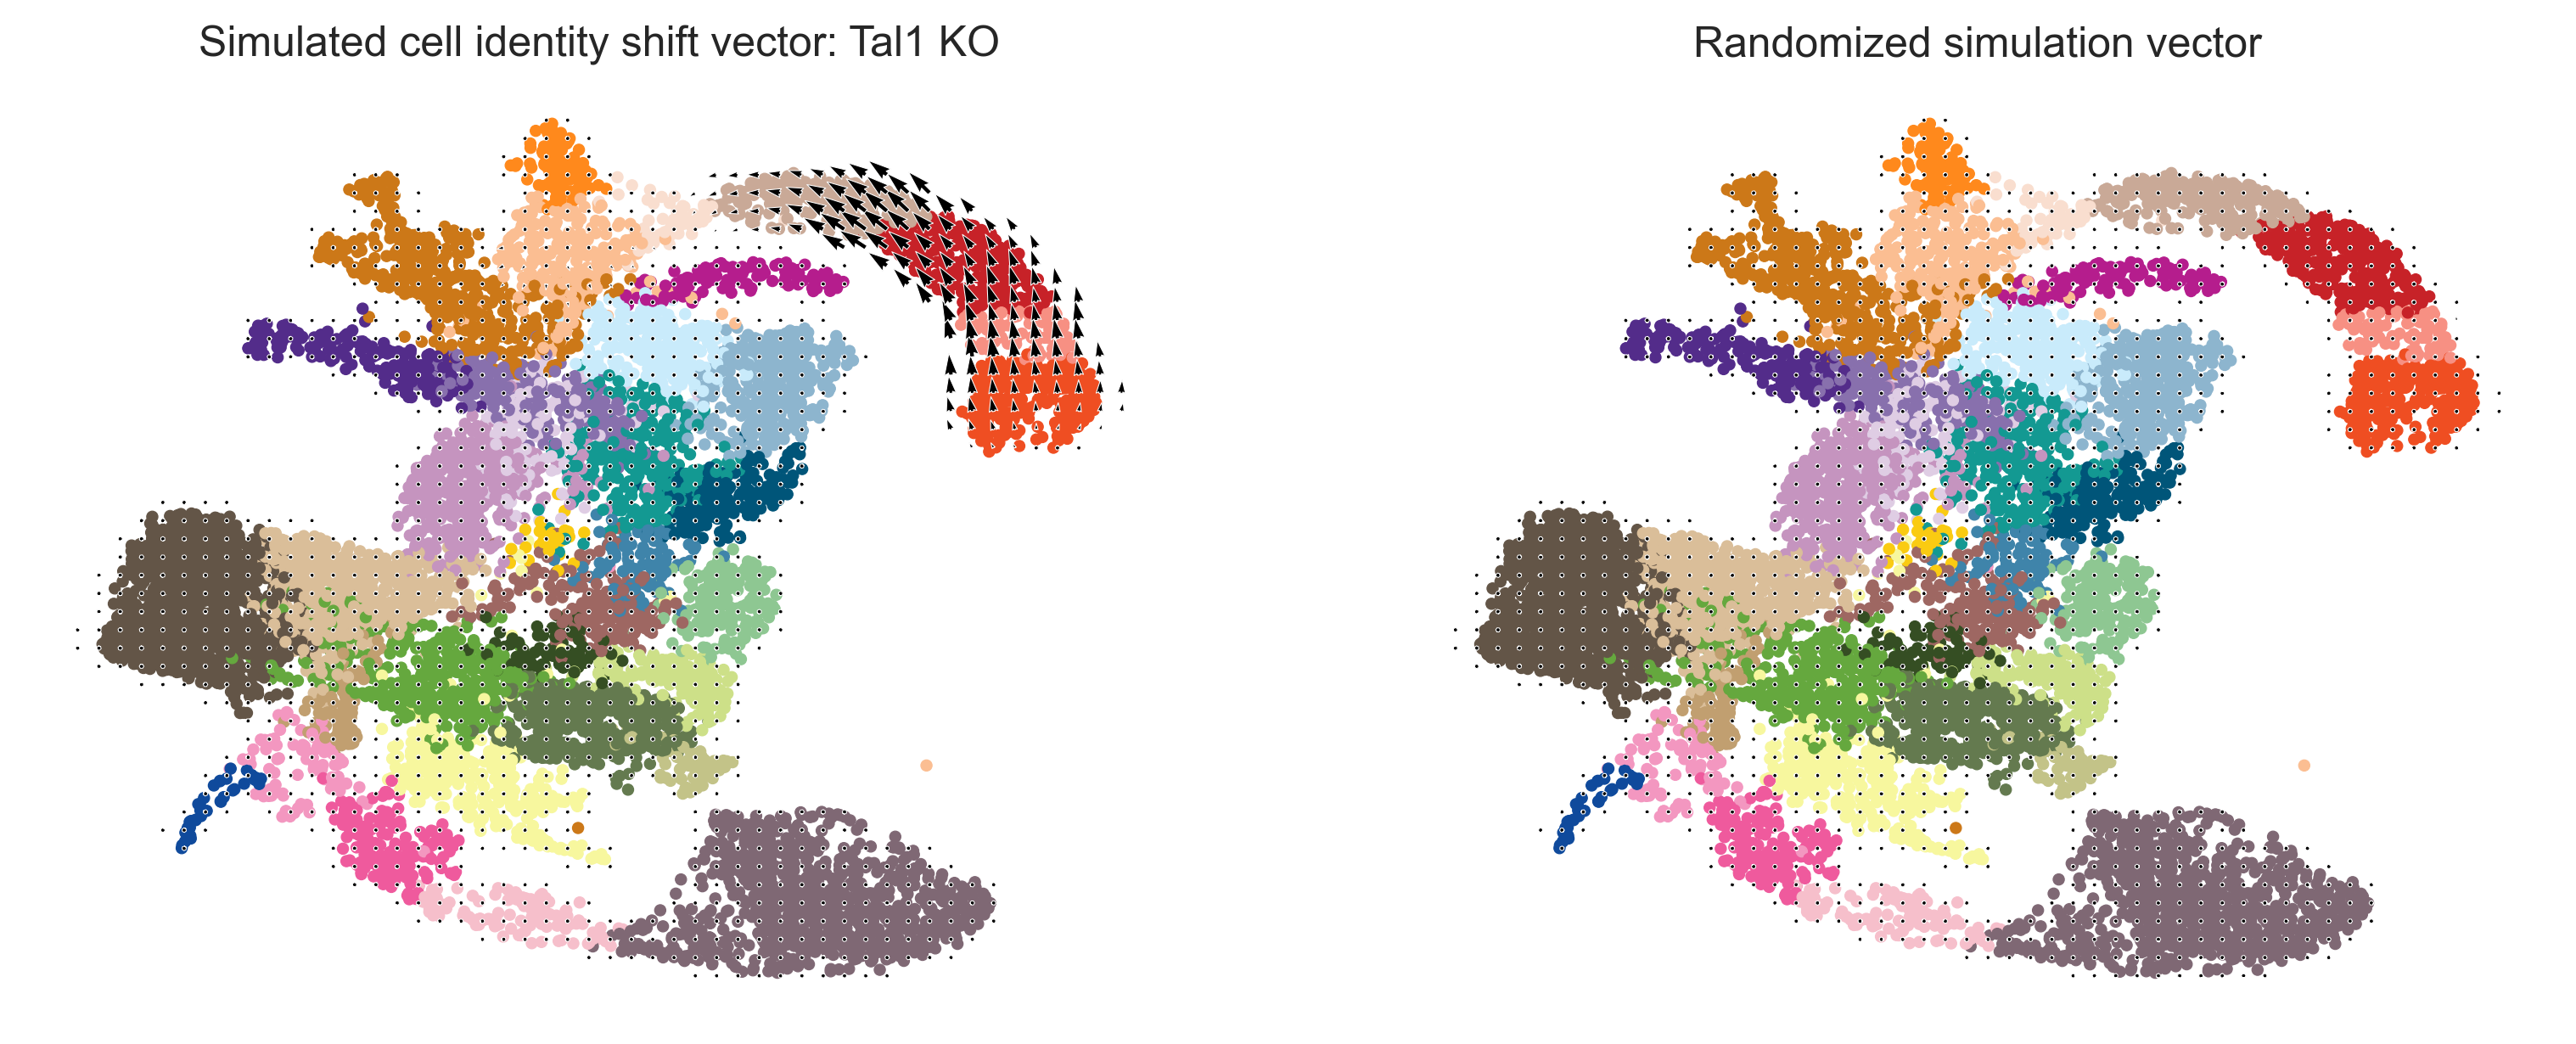

In [30]:
fig, ax = plt.subplots(1, 2,  figsize=[6.4*2, 4.8], dpi=300)

scale_simulation = 20
# Show quiver plot
oracle.plot_cluster_whole(ax=ax[0], s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0], show_background=False)
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_cluster_whole(ax=ax[1], s=10)
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1], show_background=False)
ax[1].set_title(f"Randomized simulation vector")
#plt.savefig('/disk/share/xuruihong/pygot_fig/got_celloracle.pdf', format='pdf')
plt.show()

Next, we use the same pipeline to all expressed TFs, and compute the corresponding perturbation score (PS, i.e. dot product between unperturbated and perturbated gene velocity)

In [37]:
# Screen all expressed TFs 
candidate_TF = grn.tf_names
perturb_df = []
for tf in tqdm(candidate_TF):
    oracle.simulate_shift(perturb_condition={tf: 0.0},
                      n_propagation=3)
    oracle.adata.obs['score'] = np.sum(np.array(oracle.adata.layers['delta_X']) * oracle.adata.layers['velocity'], axis=1)
    perturb_df.append(oracle.adata.obs['score'].copy())


100%|███████████████████████████████████████████████████████████████████████████████| 334/334 [55:41<00:00, 10.00s/it]


In [38]:
perturb_df = pd.DataFrame(perturb_df, index=candidate_TF).T

Visualizing PS under Tal1 KO, the PS enrich in the blood lineage cells, which is consistent with previous research

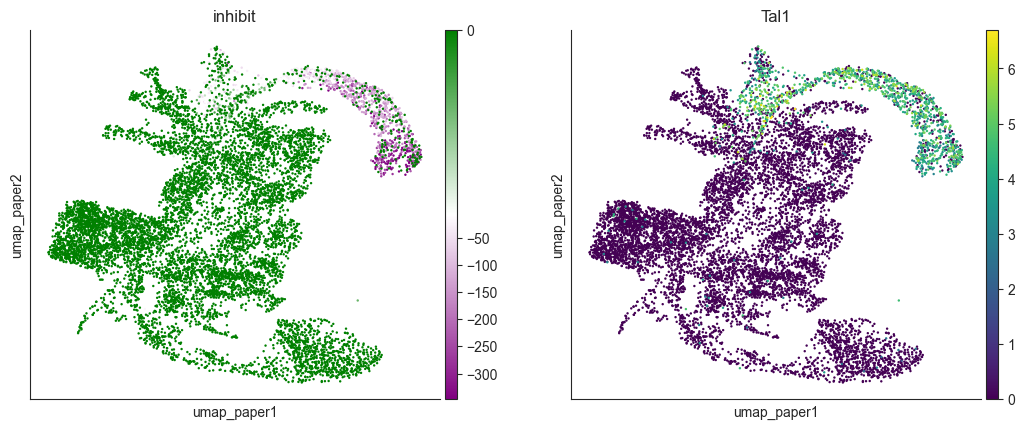

In [43]:
import matplotlib.colors as mcolors
colors = ["purple", "white", "green"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
oracle.adata.obs['inhibit'] = perturb_df['Tal1']
fig, axes = plt.subplots(1,2, figsize=(6.4*2, 4.8))

norm = mcolors.TwoSlopeNorm(vmin=np.percentile(oracle.adata.obs['inhibit'], 1), vcenter=perturb_df.mean().mean(), vmax=0)
sc.pl.embedding(oracle.adata, color='inhibit',  basis='umap_paper', cmap=custom_cmap, norm=norm, ax=axes[0], show=False)
sc.pl.embedding(oracle.adata, color='Tal1',  basis='umap_paper',layer="imputed_count", ax=axes[1], show=False, cmap='viridis')

plt.show()

Next, we compute the PS of different cell type to quantify the impact of different cell type under TF KO

In [41]:
cell_idx_list = oracle.adata.obs.groupby(cell_type_key).apply(lambda x: x.index)

In [42]:
perturb_res = []
b = perturb_df.mean().mean() # as baseline
for idx in cell_idx_list:
    perturb_res.append(perturb_df.loc[idx].mean(axis=0) - b)
perturb_res = pd.DataFrame(perturb_res, index=cell_idx_list.index)

In [44]:
benchmark_list = perturb_res.index.intersection(coda_res['Cell Type'])
groundtruth = coda_res.set_index('Cell Type').loc[benchmark_list]['log2fc']

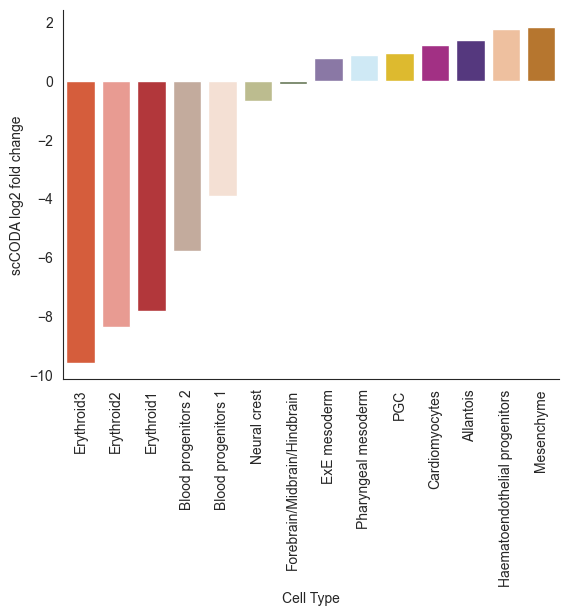

In [45]:
# Ground Truth
colors = { c:adata.uns['colored_celltypes_colors'][np.where(adata.obs[cell_type_key].cat.categories == c)[0][0]] for c in benchmark_list}
sns.barplot(coda_res.loc[coda_res['Cell Type'].isin(benchmark_list)].sort_values('log2fc'), x='Cell Type', y='log2fc', palette=colors)
plt.xticks(rotation=90)
plt.ylabel('scCODA log2 fold change')
plt.show()

The PS under simulated Tal1 KO distribution is very close to groundtruth 

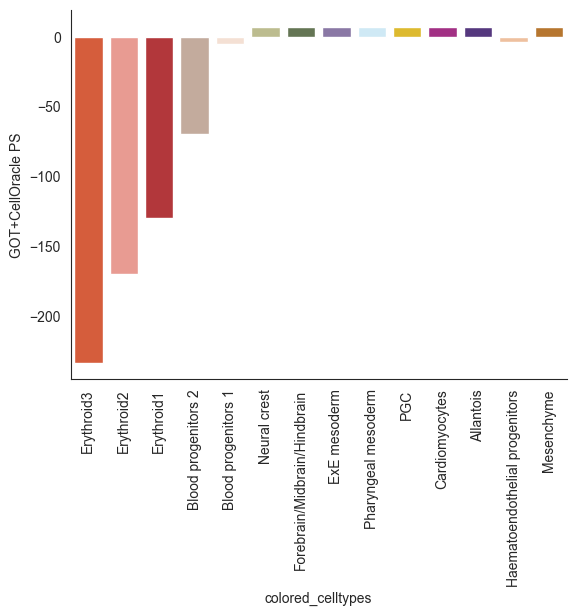

In [65]:
order = coda_res.loc[coda_res['Cell Type'].isin(benchmark_list)].sort_values('log2fc')['Cell Type']
show_df = pd.DataFrame(perturb_res.loc[benchmark_list]['Tal1']).reset_index().sort_values('Tal1').reset_index(drop=True)
show_df['colored_celltypes'] = show_df['colored_celltypes'].astype(str)
sns.barplot(show_df.sort_values('Tal1'), x='colored_celltypes', y='Tal1', palette=colors, order=order)
plt.xticks(rotation=90)
plt.ylabel('GOT+CellOracle PS')
plt.show()

Next, we compute the correlations between PS under different TF KO and groundtruth, to seek which TF mimics the impact of Tal1 KO

In [60]:
from scipy.stats import pearsonr
best_match_genes = []
for gene in perturb_res.columns:
    best_match_genes.append([gene, pearsonr(perturb_res.loc[benchmark_list][gene], groundtruth)[0]])
best_match_genes = pd.DataFrame(best_match_genes, columns=['gene', 'R']).sort_values('R', ascending=False)

Correlation result showing simulated Tal1 KO is the most correlated TF 

In [62]:
selected_gene = best_match_genes.loc[best_match_genes.gene == 'Tal1']
ranked = np.where(best_match_genes.gene == 'Tal1')[0][0]
print(ranked)
selected_gene

0


,gene,R
194,Tal1,0.921873


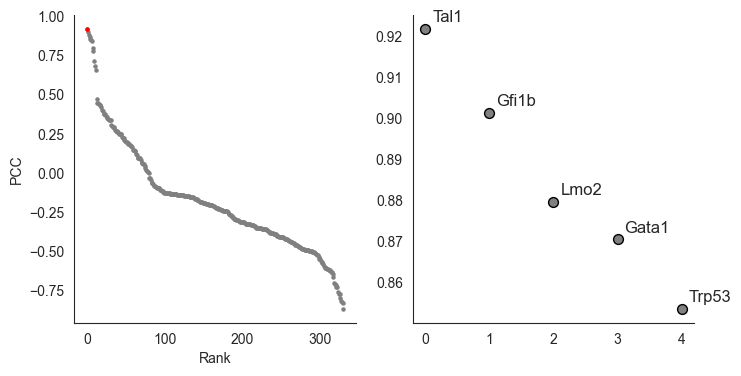

In [63]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
n_top = 5
axes[0].scatter(x=range(len(best_match_genes)), y=best_match_genes['R'].tolist(), s=5, color='grey',)
axes[0].scatter(x=ranked, y=selected_gene['R'].tolist(), s=5, color='red',)
#plt.ylabel('PCC')
#plt.xlabel('Rank')
annotated_genes = best_match_genes.head(n_top)
for i, gene in enumerate(annotated_genes.gene):
    axes[1].annotate(gene, 
                xy=(i, annotated_genes['R'].tolist()[i]), 
                xytext=(5, 5),  # 调整文本偏移量以避免覆盖数据点
                textcoords="offset points",
                ha='left',
                fontsize=12)
axes[1].scatter(x=range(len(best_match_genes))[:n_top], y=best_match_genes['R'].tolist()[:n_top], s=50, color='grey', edgecolors='black')
axes[0].set_ylabel('PCC')
axes[0].set_xlabel('Rank')
#plt.savefig('/disk/share/xuruihong/pygot_fig/got_celloracle_corr.pdf', format='pdf')
plt.show()